# Objectives ( Source Finding )

In this notebook , I simulated a single Gaussian shaped source defined by the equation:
$$\tau(X,Y,A,R) = A\exp{[-\frac{(x-X)^{2} + (y-Y)^{2}}{2R^{2}}]}$$


I used Bayesian techniques to infer the parameters of the single source i.e doing basic source finding by recovering the location X, Y and the flux(amplitude) A of the source and keeping the spatial extent R fixed.

 I evalute the posterior of the paramaters using baye's equation:
 
 $$P(X,Y,A|Data) = \frac{P(Data|(X,Y,A))P(X,Y,A)}{Z}$$
 
 where $P(Data|(X,Y,A))$ is the likelihood of the data given the parameters;$P(X,Y,A)$ is prior probbility of the parameters ; Z is the marginalizing term called the "Evidence" and $P(X,Y,A|Data)$ is the posterior of the parameters.
 
 1. To evaluate the Posterior I use Metropolis Hasting MCMC.

# Import needed Modules

In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as Makecopy
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Generate Image with One Source

### TODO: Define Gaussian shaped function

$$\tau(X,Y,A,R) = A\exp{[-\frac{(x-X)^{2} + (y-Y)^{2}}{2R^{2}}]}$$

### the above equation is used to model each source.

In [2]:
def Template_Equation(x,y,theta):

    """
         Returns Gaussian shaped Function
    
    Parameters
    
    ---------------------
    x:  array  (1,number of pixels)
        column vector
        
    y:  array (number of pixels,1)
        row vector
        
    theta : list or array
            List of parameters X , Y and A.
            
    params: list or array
            x,y - row by coloumn pix
    ---------------------- 
    
    output: Dataset
            pix by pix model"""
    X,Y,A = theta
    R = 3
    template = A*np.exp(-(((x-X)**2 + (y-Y)**2)/(2*R**2)))
    return template

# Prior [ X,Y,A]

TODO : Define functions of the prior probability on X , Y and A,

The prior probabilities on X and Y are flat priors definied by.
                
$$P(X) = \frac{1}{X_{upper}-X_{lower}}$$
$$P(Y) = \frac{1}{Y_{upper}-Y_{lower}}$$
                    
and the prior on A is an exponential prior.
                        $$P(A) = \exp{(-A)}$$

In [3]:
def LogPrior(theta,theta_limits):
    """Evaluate the prior probability of each X,Y and A
    
    Parameters
    
    ----------------
    
    theta : list or array
            [X,Y,A] parameters to be evaluated
            
    theta_limits: list or array 
            The limits of X,Y and A.
    
    ----------------
     output: scalar
            The log Prior of X,Y and A.
    
    """
    X,Y,A = theta
    Xlimits,Ylimits = theta_limits
    
    if (X < Xlimits[0]) | (X > Xlimits[1]):
        log_X_prior = -np.inf
    else:
        log_X_prior = np.log(1.0/(Xlimits[1] - Xlimits[0]))
        
    if (Y < Ylimits[0]) | (Y > Ylimits[1]):
        log_Y_prior = -np.inf
    else:
        log_Y_prior = np.log(1.0/(Ylimits[1] - Ylimits[0]))
    
    if (A<0):
        log_A_prior = -np.inf
    else:
        log_A_prior = np.log(np.exp(-A))
    
    return log_X_prior + log_Y_prior + log_A_prior

# Likelihood

TODO: I define a Gaussian log-likelihood function given by;

$$\log{L} = \sum_{i}^{n}{\log{\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}}} + \sum_{i}^{n}{-\frac{(data - model)^{2}}{2\sigma_{i}^{2}}}$$

In [4]:
def LogL(theta,data,sigmay):
    """Returns the log-likelihood the of the model given Gaussian measurement noise with standard
    deviation with known *sigmay*, where "y_data" is the known data values 
    
    Parameters
    
    ----------------
    
    model : Function
            Model function
    theta: list or array
            model parameters [X,Y,A]
    
    data : matrix
            Image data
    sigmay : matrix
            each pixel noise (Gaussian noise)
    
    ----------------
    Output: scalar
            log likelihood"""

    y_data = data
    model = Template_Equation(x,y,theta)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y_data - model)**2 / sigmay**2))
    return logL

# Posterior

TODOD: I define the posterior probability by,

$$log- Posterior = log-Likelihood + log-Prior$$

In [5]:
def LogPosterior(theta,theta_limits,data,sigmay):
    """
    Evaluates the Posterior 
    
    Parameters
    
    --------------
    
    theta : list or array
            parameters X,Y,A
            
    theta_limits: list or array
                parameter limits
                
    data: array (npix,npix)
            data set
            
    sigmay:  array (npix,npix)
            Data noise
    ---------------
    
    output: scalar
            Log-Posterior
    """
    logP = LogL(theta,data,sigmay) + LogPrior(theta,theta_limits)
    return logP

# Metropolis Hasting

In [6]:
def metropolis(log_posterior,theta,data,sigmay,stepsize, nsteps):
    
    """Metropolis Hasing MCMC
    
    Parameters
    ----------------
    log_posterior : Function
                    Log-posterior function
                    
    theta:  List or array
            Initial X,Y and A parameters
            
    data: array
            The data set
    
    sigmay: array
            Noise of each pixel
    
    stepsie: list or array
            stepsize of each paramter X,Y and A.
            
    nsteps: scalar
            Number of mcmc steps to perform.
            
    --------------
    Output : array , array , scalar
            chains ,log probabilty , acceptance ratio
    """
    #Calculate posterior of initial X,Y and A
    log_prob = log_posterior(theta,theta_limits,data,sigmay)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count accepted proposals:
    naccept = 0
    
    for i in range(nsteps): 
        theta_new = theta + stepsize * np.random.randn(len(theta)) #Generate new sample
        log_prob_new = log_posterior(theta_new,theta_limits,data, sigmay) # calculate post prob of new sample
        
        if (log_prob_new-log_prob) > np.log(np.random.rand()): # Accept new
            
            theta = theta_new        #
            log_prob = log_prob_new
            naccept += 1
            
        else:                    # Reject proposed sample
            theta = theta         #stay at current position
            
        chain[i] = theta          # record each position
        log_probs[i] = log_prob   # record loglikelihood of each position
        
    acceptance_rate = naccept/float(nsteps)     #Evaluate acceptance ratio
    
    return chain,log_probs,acceptance_rate

## TODO: 
 In this section i define the image size (pixel-by-pixel) and generate y a row vector (number of pixels,1)  and x a  column vector (1,number of pixels) to generate the Image data set.

 I then define the location X ,Y and flux A of the source.

In [7]:
npix = 50                                # number of pixels
x = np.arange(0, npix, 1, float)         #row vector
y = x[:,np.newaxis]                      #column vector


#Locations ,Spatial extent and Flux
X = 25
Y = 25
A = 15

theta_pic = np.array([X,Y,A])

#Gaussian Noise
noise_sigma = 1.0
Noise = np.random.normal(0,noise_sigma,(npix,npix))

# Image dataset
Img_data = Template_Equation(x,y,theta_pic) + Noise

## Vizualize the simulated Image

Text(0,0.5,'Arbitrary Flux')

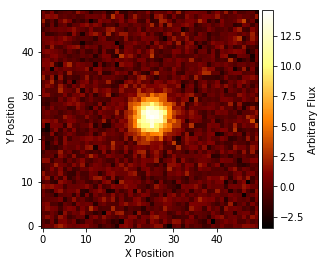

In [8]:
ax = plt.subplot(111)
im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Initial conditions

TODO: Define the initial conditions to perform mcmc

In [23]:
#Intial mcmc params
nsteps = 5000
Xstep , Ystep , Astep = 0.1,0.2,0.1
stepsize = np.array([Xstep,Ystep,Astep])

#parameter limits
Xlimits = [0.0, npix]
Ylimits = [0.0,npix]

theta_limits = (Xlimits, Ylimits)

#mcmc initial samples
X_start = 13
Y_start = 15
A_start = 10
theta = np.array([X_start,Y_start,A_start])

#define data and sigmay parameters
data = Img_data
sigmay = Noise

# Run MCMC with specified initial conditions

In [24]:
Chain,Log_probs,Acceptance = metropolis(LogPosterior,theta,data,sigmay,stepsize,nsteps)

In [25]:
print(Acceptance)

0.1038


# Check for convergence

Text(0,0.5,'A')

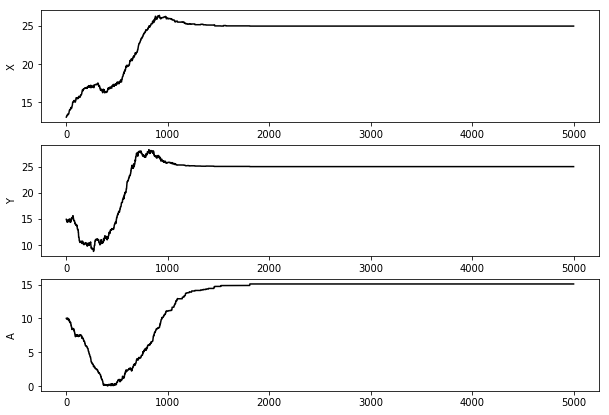

In [26]:
# Pull X ,Y and A arrays out of the Markov chain and plot them:
XX = [X for X,Y,A in Chain]
YY = [Y for X,Y,A in Chain]
AA = [A for X,Y,A in Chain]

# Traces, for convergence inspection:
plt.figure(figsize=(10,7))
plt.subplot(3,1,1)
plt.plot(XX, 'k-')
plt.ylabel('X')

plt.subplot(3,1,2)
plt.plot(YY, 'k-')
plt.ylabel('Y')

plt.subplot(3,1,3)
plt.plot(AA, 'k-')
plt.ylabel('A')

# Evaluate the mean of X,Y and A

In [27]:
Mean_X = np.mean(XX[600:])
Mean_Y = np.mean(YY[600:])
Mean_A = np.mean(AA[600:])

# Vizualize the Image with the estimated parameters

Text(0,0.5,'Arbitrary Flux')

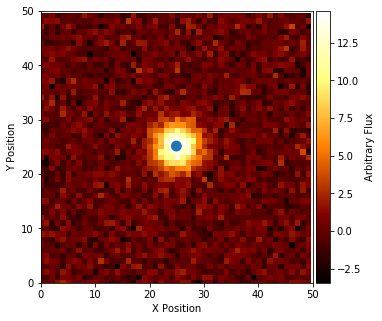

In [28]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [Mean_X]
Y_pos = [Mean_Y]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=2, height=2, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)

im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Evaluate Z

# TODO: 

Given that we have evaluated the likelihood values, we can calculate the evidence by

$$Z = \sum_{i}^{n}{L_{i}w_{i}}$$

where $w_{i} = X_{i+1}-X_{i}$ and since X the prior mass decreases from 1 to 0 by a factor of $e^{-1}$ we can evaluate the estimate of Z. 

In [29]:
for i in range(0, nsteps):
    logX = -(np.arange(0, i+1) + 1.)/nsteps
    
logwt = logX.copy() + Log_probs
wt = np.exp(logwt - logwt.max())

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result

# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)

# Calculate marginal likelihood
logZ = logsumexp(logw + Log_probs)
print('logZ :',logZ)

logZ : -2031.9348634400858
